# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [4]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [5]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [6]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [7]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

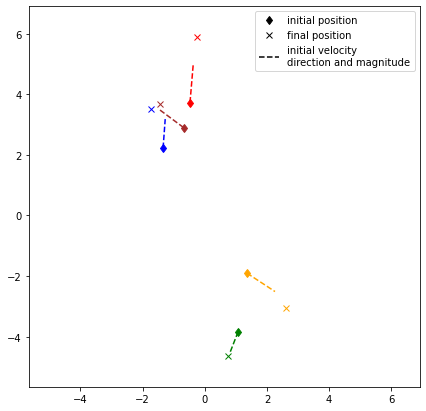

In [8]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [5]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [6]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Implementation

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModel(torch.nn.Module):
    def __init__(self, device, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 32, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 32,
                 hidden_dim: int = 32, output_shape: int = 2, horizon_length: int = 3):
        super(ParticleModel, self).__init__()
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.ReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.ReLU())
        self.embedding_size = (set_size, gamma1_out)

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.ReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out),
                                              nn.ReLU())
        self.deepset_output = (set_size, gamma2_out)
        

        #####
        # Recurrent Part
        self.rnn = nn.LSTM(gamma2_out*set_size, hidden_dim, num_layers = 1, batch_first = True)

        # Fully connected layer after RNN output, to learn more complex relations
        self.final = nn.Linear(hidden_dim, output_shape*set_size)

        # auxiliary veriable to store the device
        self.device = device
        self.output_shape = output_shape
        self.horizon_length = horizon_length

    
    def forward_iteration1(self, particle_set, distances):
        embedding = torch.zeros((particle_set.shape[0], self.embedding_size[0], self.embedding_size[1])).to(self.device)
        
        for i in range(particle_set.shape[1]):
            # concatenate the neighborhood
            x = torch.cat([particle_set[:,i].reshape((particle_set.shape[0], 1, 5)).repeat((1, particle_set.shape[1] - 1, 1)),
                           particle_set[:, list(set(range(particle_set.shape[1])).difference({i}))],
                           distances[:, i, list(set(range(particle_set.shape[1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                   particle_set.shape[1]-1,1))],
                          2).to(self.device)


            x = self.fau_iteration1(x)

            # aggregation function
            # mean as a placeholder for now
            x = x.mean(axis = 1)
            # concatenate 
            x = torch.cat([particle_set[:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embedding[:,i] = self.gamma_iteration1(x).view(embedding[:,i].shape)
        return embedding

    def forward_iteration2(self, particle_set, distances):
        embedding = torch.zeros((particle_set.shape[0], self.deepset_output[0], self.deepset_output[1])).to(self.device)
        for i in range(particle_set.shape[1]):
            # concatenate the neighborhood
            x = torch.cat([particle_set[:,i].reshape((particle_set.shape[0], 1, particle_set.shape[2])).repeat((1, particle_set.shape[1] - 1, 1)),
                           particle_set[:, list(set(range(particle_set.shape[1])).difference({i}))],
                           distances[:, i, list(set(range(particle_set.shape[1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                   particle_set.shape[1]-1,1))],
                          2).to(self.device)

            x = self.fau_iteration2(x)

            # aggregation function
            # mean as a placeholder for now
            x = x.mean(axis = 1)

            
            # concatenate 
            x = torch.cat([particle_set[:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)    

            embedding[:,i] = self.gamma_iteration2(x).view(embedding[:,i].shape)
        return embedding

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set], dim=0).to(self.device)
        p1 = self.forward_iteration1(particle_set = particle_set, distances = distances)
        out = self.forward_iteration2(particle_set=p1, distances=distances).reshape((particle_set.shape[0], 1, -1))
        
        zeros = torch.zeros((particle_set.shape[0], self.horizon_length, self.deepset_output[0]*self.deepset_output[1])).to(self.device) 
        #(batch_size, 1, embedding_dim)
        rnn_input = torch.cat([out, zeros], dim=1)
        
        
        # Input: (Batch size, L (sequence length), input_shape)
        # rnn_output: (Batch size, L (sequence length), output_shape)
        rnn_output, rnn_state = self.rnn(rnn_input)

        #print(f'{rnn_output[:,1:,:].shape}')
        # To further process, put the data through a dense layer
        output = self.final(rnn_output[:,1:,:])
        
        #print(f'{output.shape}')
        # (batch_size, horizon_length, output_shape, set_size)
        return output.view((output.shape[0], self.horizon_length, self.output_shape, -1))

----

Model check

In [25]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device, set_size = 5, input_size = 5, 
                 fau1_out = 8, gamma1_out = 16, fau2_out = 16, gamma2_out = 32,
                 hidden_dim = 32, output_shape = 2, horizon_length= 3).to(device)

tf, tl = next(iter(train_dataloader))

In [27]:
model(tf.float().to(device)).shape

torch.Size([64, 3, 32])
torch.Size([64, 3, 10])


torch.Size([64, 3, 2, 5])

# Model Training

In [30]:
from tqdm import tqdm

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            for x, y in self.training_DataLoader:

                x, y = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                out = self.model(x)
                #print(f'{y.shape} and {out.shape}')

                loss = self.criterion(y, out)
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                x,y = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    out = self.model(x)
                    #print(f'{y.shape} and {out.shape}')
                    loss = self.criterion(y, out)
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self):

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = [0,0,0]
            length = 0
            for x,y in self.testing_DataLoader:
               
                x,y = x.float().to(self.device), y.float().to(self.device)
                out = self.model(x)
                 
                for i in range(3):
                    loss[i] = (x[:,i,:,:] - y[:,i,:,:]).abs().sum(axis = 1).sum(axis = 1).sum()

                length+= x.shape[0]*x.shape[-1]
               

        print(f'L1 for 0.5 seconds: {loss[0]/length:.4f}; for 1.0 second: {loss[1]/length:.4f}, for 1.5 seconds: {loss[2]/length:.4f}',end=' ')

In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device, set_size = 5, input_size = 5, 
                 fau1_out = 8, gamma1_out = 16, fau2_out = 16, gamma2_out = 32,
                 hidden_dim = 32, output_shape = 2, horizon_length= 3).to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, #torch.nn.BCELoss(),
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)



train_loss, val_loss = TrainingProcedure.run_trainer()

  5%|████▏                                                                              | 1/20 [00:01<00:31,  1.68s/it]

EPOCH: 01/20 LOSS: 2.0999 VAL-LOSS: 1.7095


 10%|████████▎                                                                          | 2/20 [00:03<00:29,  1.66s/it]

EPOCH: 02/20 LOSS: 1.4740 VAL-LOSS: 1.2714


 15%|████████████▍                                                                      | 3/20 [00:04<00:28,  1.66s/it]

EPOCH: 03/20 LOSS: 1.1576 VAL-LOSS: 0.9959


 20%|████████████████▌                                                                  | 4/20 [00:06<00:26,  1.63s/it]

EPOCH: 04/20 LOSS: 0.8982 VAL-LOSS: 0.7943


 25%|████████████████████▊                                                              | 5/20 [00:08<00:24,  1.65s/it]

EPOCH: 05/20 LOSS: 0.7439 VAL-LOSS: 0.6820


 30%|████████████████████████▉                                                          | 6/20 [00:09<00:23,  1.65s/it]

EPOCH: 06/20 LOSS: 0.6547 VAL-LOSS: 0.6139


 35%|█████████████████████████████                                                      | 7/20 [00:11<00:21,  1.65s/it]

EPOCH: 07/20 LOSS: 0.5934 VAL-LOSS: 0.5696


 40%|█████████████████████████████████▏                                                 | 8/20 [00:13<00:19,  1.65s/it]

EPOCH: 08/20 LOSS: 0.5463 VAL-LOSS: 0.5307


 45%|█████████████████████████████████████▎                                             | 9/20 [00:14<00:18,  1.66s/it]

EPOCH: 09/20 LOSS: 0.5117 VAL-LOSS: 0.4984


 50%|█████████████████████████████████████████                                         | 10/20 [00:16<00:16,  1.67s/it]

EPOCH: 10/20 LOSS: 0.4811 VAL-LOSS: 0.4673


 55%|█████████████████████████████████████████████                                     | 11/20 [00:18<00:15,  1.71s/it]

EPOCH: 11/20 LOSS: 0.4584 VAL-LOSS: 0.4492


 60%|█████████████████████████████████████████████████▏                                | 12/20 [00:20<00:13,  1.71s/it]

EPOCH: 12/20 LOSS: 0.4387 VAL-LOSS: 0.4395


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:21<00:12,  1.72s/it]

EPOCH: 13/20 LOSS: 0.4240 VAL-LOSS: 0.4189


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [00:23<00:10,  1.72s/it]

EPOCH: 14/20 LOSS: 0.4074 VAL-LOSS: 0.4055


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [00:25<00:08,  1.73s/it]

EPOCH: 15/20 LOSS: 0.3949 VAL-LOSS: 0.3922


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [00:27<00:06,  1.73s/it]

EPOCH: 16/20 LOSS: 0.3852 VAL-LOSS: 0.3829


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [00:28<00:05,  1.74s/it]

EPOCH: 17/20 LOSS: 0.3777 VAL-LOSS: 0.3695


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [00:30<00:03,  1.75s/it]

EPOCH: 18/20 LOSS: 0.3712 VAL-LOSS: 0.3628


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [00:32<00:01,  1.78s/it]

EPOCH: 19/20 LOSS: 0.3595 VAL-LOSS: 0.3541


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:34<00:00,  1.72s/it]

EPOCH: 20/20 LOSS: 0.3530 VAL-LOSS: 0.3652


In [32]:
def evaluate(self):

    self.model.eval()
    times = [0.5, 1, 1.5]
    time_to_ind = {0.5:0, 1:1, 1.5:2}

    with torch.no_grad():
        loss = [0,0,0]
        length = 0
        for x,y in self.testing_DataLoader:
               
            x,y = x.float().to(self.device), y.float().to(self.device)
            out = self.model(x)
                 
            for i in range(3):
                loss[i] = (out[:,i,:,:] - y[:,i,:,:]).abs().sum(axis = 1).sum(axis = 1).sum()

            length+= x.shape[0]*x.shape[2]
               

    print(f'L1 for 0.5 seconds: {loss[0]/length:.4f}; for 1.0 second: {loss[1]/length:.4f}, for 1.5 seconds: {loss[2]/length:.4f}',end=' ')

In [33]:
evaluate(TrainingProcedure)

L1 for 0.5 seconds: 0.0040; for 1.0 second: 0.0063, for 1.5 seconds: 0.0093 

------

In [34]:
# (simulation id, parameters (x, y, c, v_x, v_y), particle id)
def predict(x, time):
    predictions = torch.cat([x[:,0,:]+ time*x[:,-2,:], x[:,1,:] + time*x[:,-1,:]], dim = 1)
    return predictions.view((x.shape[0], -1, x.shape[-1]))

In [35]:
times = [0.5, 1, 1.5]
loss = [0,0,0]
length = 0
for x,y in test_dataloader:    
    for i in range(3):
        pred = predict(x, times[i])
        loss[i] = (pred - y[:,i,:,:]).abs().sum(axis = 1).sum(axis = 1).sum()
    length+= x.shape[0]*x.shape[2]

print(f'L1 for 0.5 seconds: {loss[0]/length:.4f}; for 1.0 second: {loss[1]/length:.4f}, for 1.5 seconds: {loss[2]/length:.4f}',end=' ')

L1 for 0.5 seconds: 0.0016; for 1.0 second: 0.0042, for 1.5 seconds: 0.0069 

In [36]:
0.0187/0.0016

11.6875

In [37]:
0.0218/0.0042

5.190476190476191

In [38]:
 0.0253/0.0069 

3.6666666666666665

# Evaluation

### Some ideas on the experimental part:

* Try various aggregation functions: Mean, Pooling (Max and Min)
* Compare different target time as an input
* Check different losses
* Regularization to the embeddings (linear layers) (?)

In [ ]:
#todo

In [34]:
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

output.shape

torch.Size([5, 3, 20])